In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import scipy.signal
import rasterio
import rasterio.features
from rasterio import MemoryFile
from affine import Affine
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from scipy.ndimage import gaussian_filter
from shapely.geometry import Polygon, shape, MultiPolygon
import shapely
import subprocess as sp

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
S3R = S3Helper('roof-index')

# Read necessary_data
height = S3R.read_tif_from_s3_as_rio("missoula/geospatial/downtown_height.tif" ) 
flat = S3R.read_shp_from_s3_as_gpd("missoula/geospatial/contiguous_flat.zip").to_crs(6514)
bldgs = S3R.read_shp_from_s3_as_gpd('missoula/geospatial/downtown_flat_beta.zip').to_crs(6514)
bldgs = bldgs[bldgs['flat'] == 1]

## Find Inverse of Contiguous Flat Areas

<AxesSubplot:>

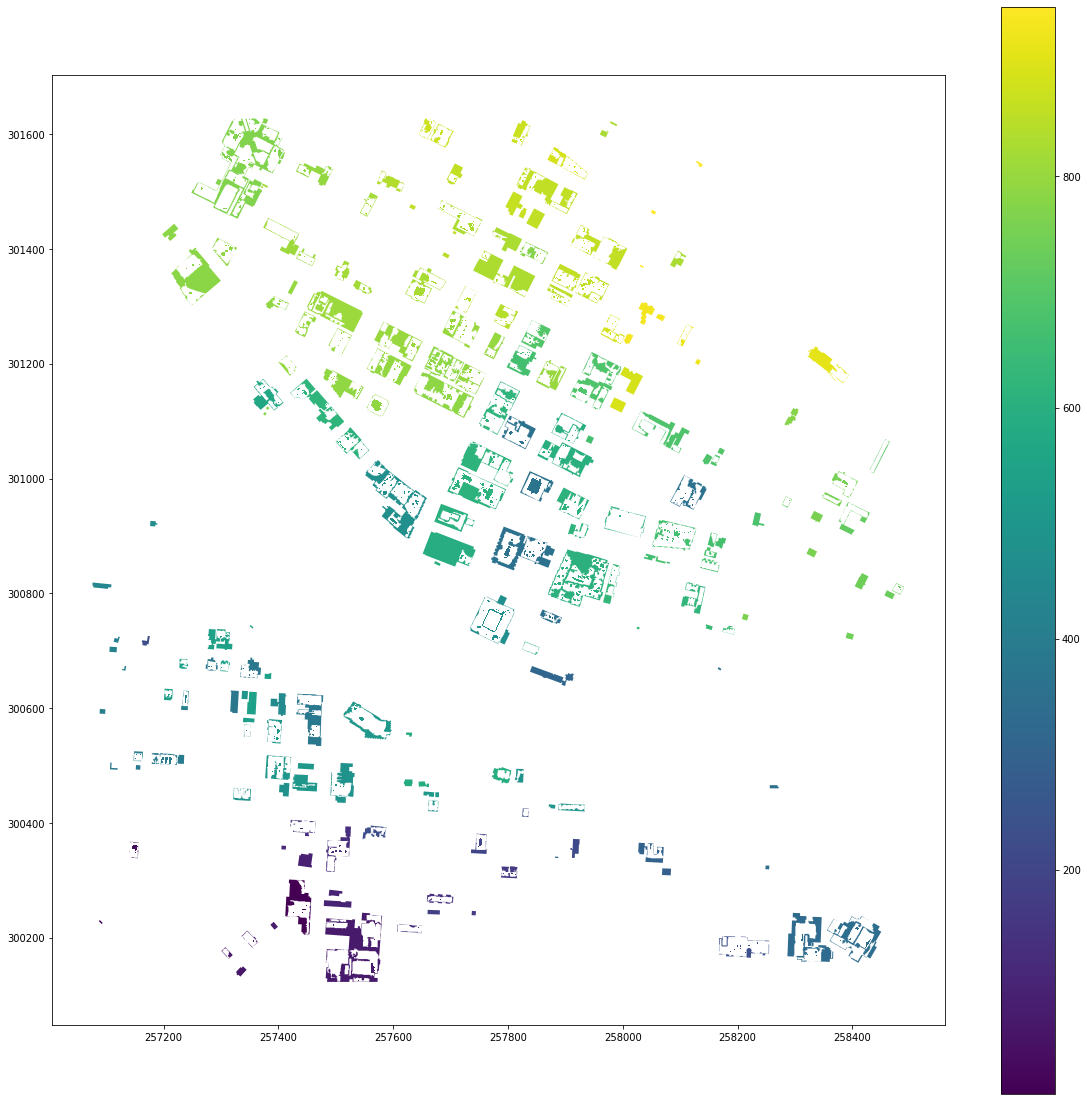

In [3]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
inverse = gpd.overlay(bldgs, flat, how='difference')
inverse.plot(ax=ax, column='fid', legend=True)

## Convert all MultiPolygons into individual Polygons so we can get height of each one

In [4]:
# Taken from https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
def explode(indf):
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

inverse = explode(inverse)
inverse['unq_id'] = range(len(inverse))

## Calculate height of each non-flat area and the height of each building 

In [14]:
def calc_height(shp, raster, id_column_name='fid', new_column_name='bldg_height'): 

    zstats = rasterstats.zonal_stats(shp, raster.read(1), affine=raster.transform,
        nodata=raster.nodata, geojson_out=True, stats="median")

    bh = []
    for b in zstats:
        bh_temp = (b['properties'][id_column_name], b['properties']['median'])
        bh.append(bh_temp)

    bh_df = gpd.GeoDataFrame(bh, columns=[id_column_name, new_column_name])
    full_data = pd.merge(shp, bh_df)
    full_data[new_column_name] = full_data[new_column_name] * 3.28084
    return full_data     

inverse_stats = calc_height(inverse, height, 'unq_id', 'inverse_height')
bldgs_stats = calc_height(bldgs, height, 'fid', 'bldg_height')
inverse_stats = inverse_stats[['fid', 'unq_id', 'geometry', 'inverse_height']]

## Calculate the volume of the non-flat areas

In [26]:
inverse_stats['inverse_area'] = inverse_stats['geometry'].area * 10.7639
merged = pd.merge(inverse_stats.drop(columns='geometry'), bldgs_stats, on='fid')
merged['rise'] = merged['inverse_height'] - merged['bldg_height']


# merged['rise'] = [0 if x < 0 else x for x in merged['rise']]

# The logic here might need to be adjusted. Right now, I'm treating areas with a 'negative' volume the same as
# areas with a positive volume by taking the absolute value.
merged['volume'] = abs(merged['rise'] * merged['inverse_area'])
merged = merged[['fid', 'volume', 'geometry']]

# Aggregate all polygons to multipolygons based on building fid
output = merged.dissolve(by='fid', aggfunc='sum')

<AxesSubplot:>

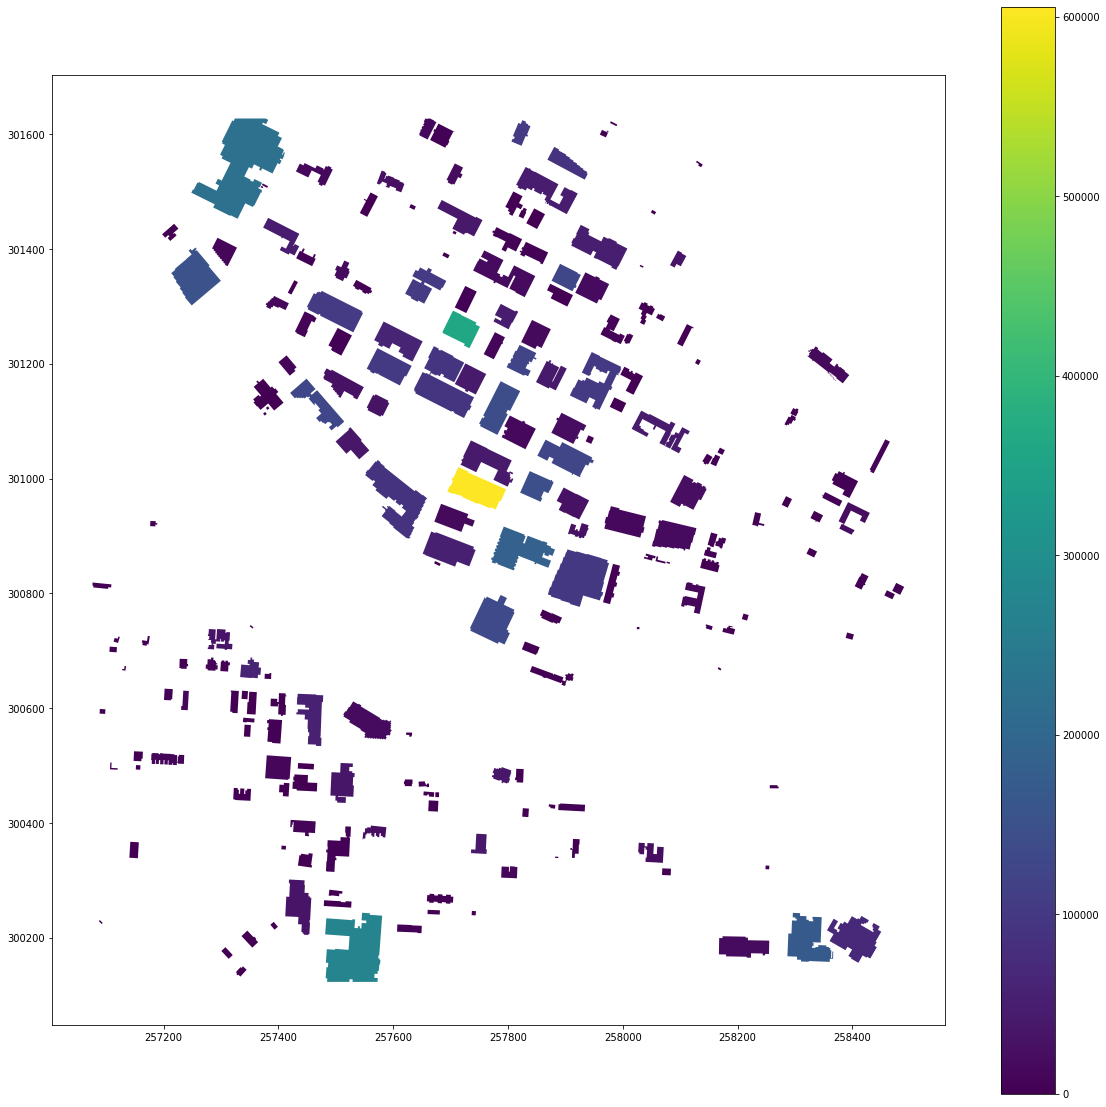

In [27]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
output.plot(column='volume', legend=True, ax=ax)